In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import v2 
import torchvision.models as models

In [2]:
image_width = 300 
image_height = 200
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Inferencing and evaluating through: {device}")

Inferencing and evaluating through: cuda


In [3]:
preprocess_image = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean, std)
])

In [4]:
dataset = []
for im_name in [x for x in os.listdir('./test-files/test_files/') if x.endswith(".jpg")]:
    image = cv2.resize(
        cv2.cvtColor(
            cv2.imread(
                f'./test-files/test_files/{im_name}', 
                cv2.IMREAD_COLOR
            ), 
            cv2.COLOR_BGR2RGB
        ), 
        (image_width, image_height)
    ) # read image, convert color space, resize all to (300, 200)
    # preprocessing data images
    image = preprocess_image(image).to(device)
    dataset.append(image)

In [5]:
class ClassificationDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [6]:
final_dataset = ClassificationDataset(dataset)

In [7]:
len(dataset)

1350

In [8]:
testloader = DataLoader(final_dataset, batch_size=48, shuffle=False)

In [9]:
# efficient net v2_l
model = models.efficientnet_v2_l(weights = None)
# checking the head's name
total_categories = 101
model.classifier = nn.Sequential(
    nn.Dropout(p = 0.5),
    nn.Linear(1280, total_categories, bias = True),
    nn.LogSoftmax(dim=1)
)
# multi gpu optimizations
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model, device_ids = [0, 1])
    final_layer = model.module.classifier
else:
    final_layer = model.classifier
# load saved checkpoint // after multi-gpu because saved model is wrapped in a module 
model.load_state_dict(torch.load('./enet/pt_yes_2_10.pth'))
model = model.to(device)

In [10]:
predictions = list()
model.eval()
with torch.no_grad():
    for data in testloader:
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        # print(outputs.data.size())
        predictions.extend(predicted.cpu().numpy())
        # break

In [11]:
outputs[0]

tensor([-2.1428e+01, -1.7436e+01, -1.7576e+01, -2.0050e+01, -2.1483e+01,
        -1.8138e+01, -1.8026e+01, -2.5641e+01, -2.3253e+01, -2.3459e+01,
        -1.8794e+01, -1.6631e+01, -2.0408e+01, -2.3711e+01, -1.9082e+01,
        -1.7144e+01, -2.0648e+01, -2.1567e+01, -2.2366e+01, -2.7179e-05,
        -2.1206e+01, -1.7524e+01, -2.1153e+01, -2.1132e+01, -2.2721e+01,
        -1.9501e+01, -2.5523e+01, -2.0368e+01, -2.2060e+01, -1.7748e+01,
        -2.2413e+01, -2.1220e+01, -2.1798e+01, -2.4078e+01, -1.8356e+01,
        -2.3137e+01, -1.9387e+01, -2.3131e+01, -2.1762e+01, -2.3121e+01,
        -1.7705e+01, -2.4403e+01, -2.1052e+01, -2.4079e+01, -2.0543e+01,
        -2.2565e+01, -1.8663e+01, -2.0500e+01, -1.8541e+01, -1.0769e+01,
        -2.0117e+01, -2.2919e+01, -2.3277e+01, -1.4482e+01, -2.5028e+01,
        -2.0700e+01, -2.0126e+01, -2.3319e+01, -2.8311e+01, -2.3807e+01,
        -2.0939e+01, -1.8753e+01, -2.4411e+01, -2.7171e+01, -2.3207e+01,
        -2.8298e+01, -1.5752e+01, -1.2336e+01, -1.9

In [12]:
print(predictions)

[85, 85, 22, 19, 58, 63, 35, 35, 76, 4, 35, 69, 9, 77, 15, 43, 50, 22, 98, 69, 43, 74, 68, 2, 69, 77, 91, 98, 6, 46, 2, 12, 77, 79, 44, 42, 77, 59, 85, 22, 43, 77, 77, 34, 25, 66, 18, 48, 22, 12, 98, 56, 77, 37, 17, 65, 54, 60, 39, 69, 82, 91, 69, 69, 84, 64, 22, 39, 5, 90, 54, 66, 41, 2, 36, 89, 12, 7, 69, 36, 46, 90, 20, 41, 50, 9, 25, 22, 58, 23, 77, 85, 15, 11, 77, 29, 77, 38, 21, 2, 69, 84, 96, 67, 79, 20, 19, 73, 68, 21, 20, 69, 10, 50, 35, 62, 78, 59, 85, 85, 22, 85, 78, 78, 33, 23, 46, 58, 75, 7, 56, 75, 77, 22, 89, 5, 77, 77, 67, 66, 59, 46, 77, 77, 32, 77, 70, 5, 69, 15, 71, 69, 49, 70, 77, 32, 0, 52, 41, 38, 71, 66, 85, 8, 100, 77, 71, 22, 37, 22, 95, 21, 38, 38, 77, 57, 69, 75, 27, 52, 47, 99, 54, 69, 22, 69, 77, 76, 77, 69, 35, 39, 51, 0, 10, 77, 18, 47, 69, 22, 94, 45, 78, 77, 38, 0, 14, 58, 98, 73, 85, 19, 49, 63, 55, 89, 77, 7, 98, 77, 69, 98, 60, 66, 72, 34, 46, 56, 77, 35, 69, 23, 37, 69, 95, 77, 68, 18, 40, 3, 9, 12, 57, 69, 22, 39, 22, 28, 38, 26, 45, 44, 27, 16, 60

In [13]:
import random
indexes = random.sample(range(len(predictions)), 10)

In [14]:
sampled = {x: predictions[x] for x in indexes}
sampled

{142: 77,
 1173: 70,
 28: 6,
 784: 22,
 649: 5,
 8: 76,
 1054: 46,
 679: 69,
 735: 22,
 656: 24}

In [15]:
# predicted_df = pd.DataFrame()
# for idx, cat in sampled.items():
#     predicted_df = predicted_df.append({
#         'image_name': f'test-files/test_files/{os.listdir("./test-files/test_files/")[idx]}',
#         'category': cat
#     }, ignore_index=True)

In [16]:
train_data = pd.read_csv('./proper_labels.csv')

In [17]:
train_data.head()

,filename,file_index,category
0,file-002802.jpg,2802,38
1,file-000973.jpg,973,18
2,file-000967.jpg,967,17
3,file-002816.jpg,2816,38
4,file-006480.jpg,6480,85


142: 77


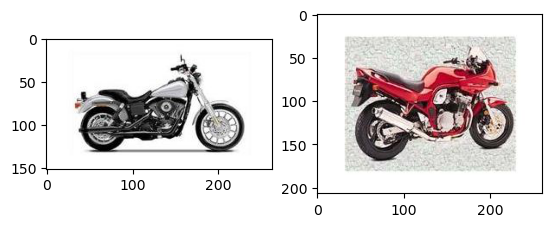

1173: 70


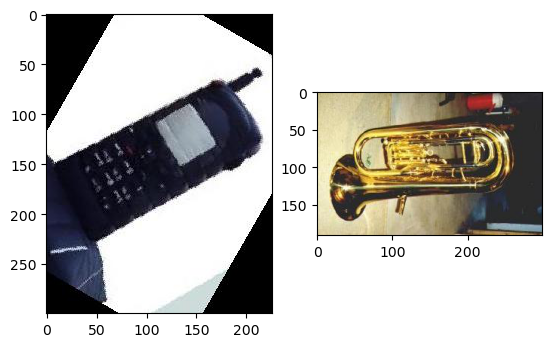

28: 6


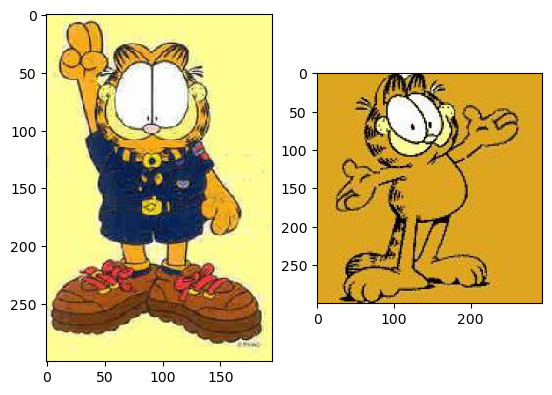

784: 22


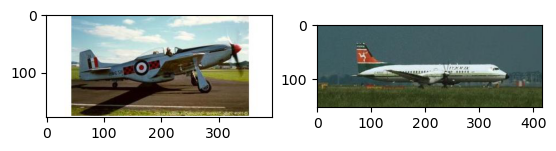

649: 5


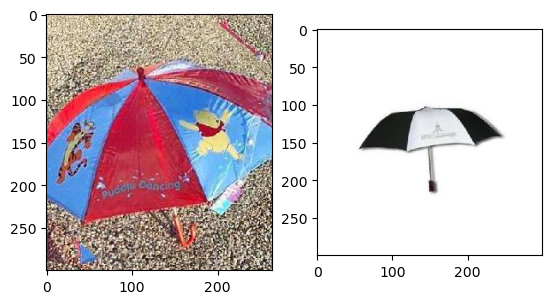

8: 76


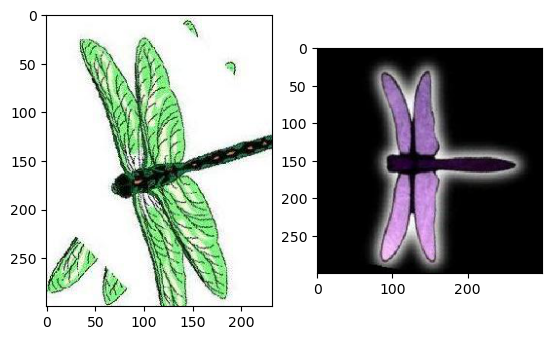

1054: 46


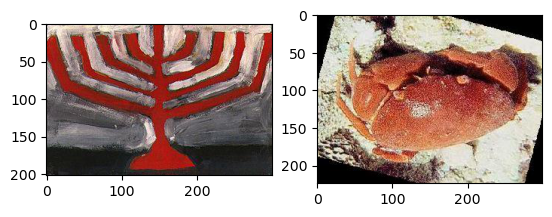

679: 69


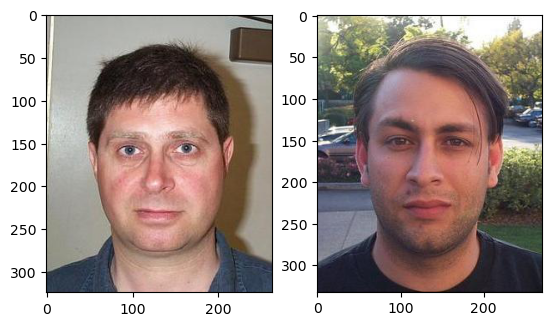

735: 22


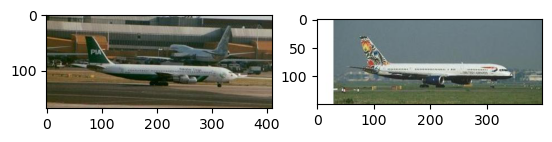

656: 24


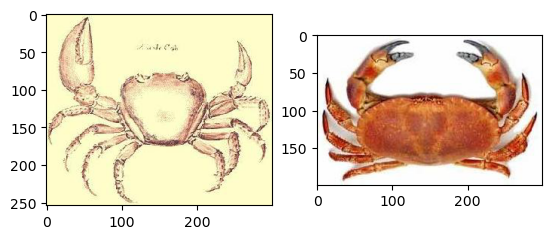

In [18]:
idx_image = 0
for idx, sample in sampled.items():
    fig, ax = plt.subplots(1, 2)
    cat = sample
    same_cat_data = train_data[train_data['category'] == cat]
    # print(len(same_cat_data))
    try:
        filename = same_cat_data.iloc[random.randint(0, len(same_cat_data))]['filename']
    except:
        filename = same_cat_data.iloc[0]['filename']
    test_image = os.listdir(f'./test-files/test_files/')[idx]
    print(f'{idx}: {cat}')
    ax[0].imshow(cv2.cvtColor(cv2.imread(f'./train-files/train_files/{filename}'), cv2.COLOR_BGR2RGB))
    ax[1].imshow(cv2.cvtColor(cv2.imread(f'./test-files/test_files/{test_image}'), cv2.COLOR_BGR2RGB))
    plt.show()

In [19]:
# fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# ax[0].imshow(cv2.cvtColor(cv2.imread(f'./train-files/train_files/{filename}'), cv2.COLOR_BGR2RGB))